In [1]:
# ====================INIT RUN THIS FIRST ====================

!pip install open_clip_torch transformers
!pip install peft

import open_clip
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path
from typing import List, Dict, Tuple, Optional, Union, Any
import numpy as np
from tqdm import tqdm
import json
from torchvision import transforms
import random
from peft import LoraConfig, get_peft_model
import time
import os
def seed_everything(seed=42):
    """
    Sets the seed for the entire pipeline to ensure reproducibility.
    """
    # 1. Set Python's built-in random seed
    random.seed(seed)
    
    # 2. Set Python's hash seed (affects dictionary iteration order, etc.)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    # 3. Set NumPy's random seed (used for data splitting/sampling)
    np.random.seed(seed)
    
    # 4. Set PyTorch's random seed (used for weight initialization, dropout)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using multi-GPU
    
    # 5. Force strict deterministic algorithms (Slightly slower, but reproducible)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print(f"Global seed set to {seed}")

seed_everything(42)

synset_to_caption = {
    "n02457408": "three-toed sloth",
    "n02101006": "Gordon setter dog",
    "n02950826": "cannon",
    "n03854065": "organ keyboard instrument",
    "n02219486": "ant",
    "n03888605": "parallel bars",
    "n03017168": "chime or bell",
    "n01558993": "robin bird",
    "n02108551": "Tibetan mastiff dog",
    "n03676483": "lipstick",
    "n03400231": "frying pan",
    "n03838899": "oboe",
    "n03347037": "fire screen",
    "n04509417": "unicycle",
    "n03062245": "cocktail shaker",
    "n04149813": "scoreboard",
    "n03337140": "file cabinet",
    "n04522168": "vase",
    "n02966193": "car radiator grille",
    "n13133613": "ear of corn",
    "n03207743": "dishwasher",
    "n02091831": "Saluki dog",
    "n04612504": "yawl sailboat",
    "n03770439": "minivan",
    "n02091244": "Ibizan hound",
    "n03924679": "photocopier",
    "n02111277": "Newfoundland dog",
    "n02981792": "chain saw",
    "n07747607": "orange fruit",
    "n04418357": "theater curtain",
    "n01981276": "king crab",
    "n02113712": "miniature poodle",
    "n01855672": "goose",
    "n04604644": "worm fence",
    "n04251144": "snorkel",
    "n02108915": "French bulldog",
    "n04275548": "spatula",
    "n03272010": "electric guitar",
    "n02795169": "barber chair",
    "n13054560": "bolete mushroom",
    "n02823428": "beer bottle",
    "n04596742": "wok",
    "n03775546": "mixing bowl",
    "n09256479": "coral reef",
    "n03476684": "hair slide",
    "n02099601": "golden retriever",
    "n02110063": "malamute dog",
    "n04146614": "school bus",
    "n01930112": "nematode worm",
    "n01532829": "house sparrow",
    "n02165456": "ladybug",
    "n07697537": "hotdog sandwich",
    "n04515003": "upright piano",
    "n03544143": "hourglass",
    "n03527444": "holster",
    "n06794110": "street sign",
    "n02129165": "lion",
    "n04067472": "reflex camera",
    "n01704323": "triceratops",
    "n03047690": "clog shoe",
    "n03417042": "garbage truck",
    "n02089867": "Walker hound",
    "n02074367": "dugong",
    "n02120079": "Arctic fox",
    "n03220513": "dome",
    "n02114548": "white wolf",
    "n03075370": "combination lock",
    "n02443484": "black-footed ferret",
    "n04243546": "slot machine",
    "n01749939": "green mamba",
    "n01770081": "harvestman spider",
    "n03584254": "iPod",
    "n02687172": "aircraft carrier",
    "n02971356": "cardigan sweater",
    "n02606052": "rock beauty fish",
    "n02174001": "rhinoceros beetle",
    "n01910747": "jellyfish",
    "n09246464": "cliff",
    "n03127925": "crash helmet",
    "n07613480": "trifle dessert",
    "n02110341": "dalmatian dog",
    "n04296562": "stage",
    "n04443257": "tobacco shop",
    "n02105505": "komondor dog",
    "n03535780": "horizontal bar",
    "n04389033": "tank",
    "n02116738": "African hunting dog",
    "n02747177": "ashcan trash bin",
    "n03773504": "missile",
    "n02108089": "boxer dog",
    "n03146219": "cuirass armor",
    "n03980874": "poncho",
    "n03908618": "pencil box",
    "n01843383": "toucan",
    "n04258138": "solar dish",
    "n03998194": "prayer rug",
    "n07584110": "consomme soup",
    "n04435653": "tile roof",
    "n02138441": "meerkat",
    "n02871525": "book jacket"
}
import os

src_root = "/kaggle/input/mini-image-net-fewshot-dataset/asd2/mini_imagenet_fewshot"
dst_root = "/kaggle/working/mini_imagenet_fewshot_renamed"

splits = ["train", "validation", "test"]

# create output dirs
for split in splits:
    os.makedirs(os.path.join(dst_root, split), exist_ok=True)

# symlink each class folder with a new readable name
for split in splits:
    split_src = os.path.join(src_root, split)
    split_dst = os.path.join(dst_root, split)

    for synset in os.listdir(split_src):
        readable = synset_to_caption.get(synset, synset).replace(" ", "_")
        src_path = os.path.join(split_src, synset)
        dst_path = os.path.join(split_dst, readable)

        # create symlink
        if not os.path.exists(dst_path):
            os.symlink(src_path, dst_path)
            #print(f"🔗 Linked {synset} → {readable}")
print("finished")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 15.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Global seed set to 42
finished


In [2]:
# ====================EXP 01 FULL ====================

import open_clip
import torch
import torch.nn.functional as F
from PIL import Image
from pathlib import Path
from typing import List, Dict, Tuple
import numpy as np
from tqdm import tqdm
import json

class CoCaFewShotBenchmark:
    def __init__(
        self,
        model_name: str = "coca_ViT-L-14",
        pretrained: str = "mscoco_finetuned_laion2B-s13B-b90k",
        device: str = "cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.device = device
        print(f"Loading CoCa model on {device}...")
        
        self.model, _, self.transform = open_clip.create_model_and_transforms(
            model_name=model_name,
            pretrained=pretrained
        )
        self.model = self.model.to(device)
        self.model.eval()
        
        self.tokenizer = open_clip.get_tokenizer(model_name)
        
    def create_text_prompts(self, class_name: str) -> List[str]:
        # Clean up class name (replace underscores with spaces)
        clean_name = class_name.replace("_", " ")
        
        templates = [
            f"a photo of a {clean_name}",
            f"an image of a {clean_name}",
            f"a picture of a {clean_name}",
            f"a {clean_name}",
            f"the {clean_name}",
        ]
        return templates
    
    def encode_text_prompts(self, prompts: List[str]) -> torch.Tensor:
        with torch.no_grad(), torch.cuda.amp.autocast():
            text_tokens = self.tokenizer(prompts).to(self.device)
            text_features = self.model.encode_text(text_tokens)
            text_features = F.normalize(text_features, dim=-1)
            # Average across prompts
            text_prototype = text_features.mean(dim=0)
            text_prototype = F.normalize(text_prototype, dim=-1)
        return text_prototype
    
    def encode_image(self, image_path: Path) -> torch.Tensor:
        with torch.no_grad(), torch.cuda.amp.autocast():
            image = Image.open(image_path).convert("RGB")
            image_tensor = self.transform(image).unsqueeze(0).to(self.device)
            image_features = self.model.encode_image(image_tensor)
            image_features = F.normalize(image_features, dim=-1)
        return image_features.squeeze(0)
    
    def build_class_prototypes(
        self,
        train_dir: Path,
        n_shot: int = 5,
        text_weight: float = 0.5
    ) -> Tuple[Dict[str, torch.Tensor], List[str]]:
        class_prototypes = {}
        class_names = []
        
        # Get all class directories
        class_dirs = sorted([d for d in train_dir.iterdir() if d.is_dir()])
        
        # Only print this for the first run or if explicitly debugging to reduce spam
        # print(f"\nBuilding {n_shot}-shot prototypes (alpha={text_weight})...")
        
        for class_dir in class_dirs:
            class_name = class_dir.name
            class_names.append(class_name)
            
            # Get image paths (limit to n_shot)
            image_paths = sorted(class_dir.glob("*.jpg"))[:n_shot]
            
            # Encode images
            image_embeddings = []
            for img_path in image_paths:
                img_emb = self.encode_image(img_path)
                image_embeddings.append(img_emb)
            
            # Handle 0-shot case (pure text) or N-shot case
            if len(image_embeddings) > 0:
                image_prototype = torch.stack(image_embeddings).mean(dim=0)
                image_prototype = F.normalize(image_prototype, dim=-1)
            else:
                # If 0 images found (or 0-shot requested), rely 100% on text
                image_prototype = torch.zeros(768).to(self.device) 
                if text_weight < 1.0:
                    print(f"Warning: No images for {class_name}, but text_weight < 1.0")

            # Create and encode text prompts
            text_prompts = self.create_text_prompts(class_name)
            text_prototype = self.encode_text_prompts(text_prompts)
            
            # Combine text and image prototypes
            # If text_weight is 0, we use only image. If 1, only text.
            class_prototype = (
                text_weight * text_prototype + 
                (1 - text_weight) * image_prototype
            )
            class_prototype = F.normalize(class_prototype, dim=-1)
            
            class_prototypes[class_name] = class_prototype
        
        return class_prototypes, class_names
    
    def evaluate(
        self,
        test_dir: Path,
        class_prototypes: Dict[str, torch.Tensor],
        class_names: List[str]
    ) -> Dict[str, float]:
        correct = 0
        total = 0
        per_class_correct = {name: 0 for name in class_names}
        per_class_total = {name: 0 for name in class_names}
        
        # Stack all prototypes
        prototype_matrix = torch.stack([class_prototypes[name] for name in class_names])
        
        test_class_dirs = sorted([d for d in test_dir.iterdir() if d.is_dir()])
        
        # Use tqdm only on the outer evaluation loop to keep output clean
        for test_class_dir in tqdm(test_class_dirs, desc="Evaluating", leave=False):
            true_class = test_class_dir.name
            test_images = sorted(test_class_dir.glob("*.jpg"))
            
            for img_path in test_images:
                img_embedding = self.encode_image(img_path)
                similarities = img_embedding @ prototype_matrix.T
                pred_idx = similarities.argmax().item()
                pred_class = class_names[pred_idx]
                
                total += 1
                per_class_total[true_class] += 1
                if pred_class == true_class:
                    correct += 1
                    per_class_correct[true_class] += 1
        
        overall_accuracy = (correct / total) * 100 if total > 0 else 0
        
        per_class_accuracy = {
            name: (per_class_correct[name] / per_class_total[name] * 100) 
            if per_class_total[name] > 0 else 0
            for name in class_names
        }
        
        mean_per_class_accuracy = np.mean(list(per_class_accuracy.values()))
        
        return {
            "overall_accuracy": overall_accuracy,
            "mean_per_class_accuracy": mean_per_class_accuracy,
            "total_samples": total,
            "correct_predictions": correct,
            "per_class_accuracy": per_class_accuracy
        }
    
    def run_benchmark(
        self,
        dataset_dir: Path,
        n_shot: int = 5,
        text_weight: float = 0.5,
        save_results: bool = True
    ) -> Dict:
        train_dir = dataset_dir / "train"
        test_dir = dataset_dir / "test"
        
        class_prototypes, class_names = self.build_class_prototypes(
            train_dir, n_shot, text_weight
        )
        
        results = self.evaluate(test_dir, class_prototypes, class_names)
        
        # Print short summary line instead of full block
        print(f"Done: {n_shot}-shot, alpha={text_weight} -> Acc: {results['overall_accuracy']:.2f}%")
        
        if save_results:
            # Include alpha in filename to avoid overwriting
            output_file = f"coca_results_{n_shot}shot_alpha{text_weight}.json"
            with open(output_file, 'w') as f:
                serializable_results = results.copy()
                serializable_results["per_class_accuracy"] = {
                    k: float(v) for k, v in results["per_class_accuracy"].items()
                }
                json.dump(serializable_results, f, indent=2)
        
        return results


def main():
    # Configuration
    DATASET_DIR = Path("/kaggle/working/mini_imagenet_fewshot_renamed")
    
    # === GRID SEARCH CONFIGURATION ===
    N_SHOTS = [1, 3, 5, 10, 20] 
    TEXT_WEIGHTS = [0.0, 0.2, 0.5, 0.7] # The alphas to test
    
    benchmark = CoCaFewShotBenchmark()
    
    # Dictionary to store all results: all_results[n_shot][text_weight] = accuracy
    matrix_results = {} 
    
    print(f"\nStarting Grid Search over {len(N_SHOTS)} shot settings and {len(TEXT_WEIGHTS)} text weights.")
    print("="*60)

    for n_shot in N_SHOTS:
        matrix_results[n_shot] = {}
        for alpha in TEXT_WEIGHTS:
            
            results = benchmark.run_benchmark(
                dataset_dir=DATASET_DIR,
                n_shot=n_shot,
                text_weight=alpha,
                save_results=True
            )
            
            # Store just the overall accuracy for the summary table
            matrix_results[n_shot][alpha] = results['overall_accuracy']

    # ==========================================
    # FINAL SUMMARY TABLE (Matches your LaTeX)
    # ==========================================
    print("\n" + "="*70)
    print("FINAL HYBRID PROTOTYPE RESULTS (Accuracy %)")
    print("="*70)
    
    # Print Header
    header = f"{'N-Shot':<10} |"
    for alpha in TEXT_WEIGHTS:
        header += f" alpha={alpha:<5} |"
    print(header)
    print("-" * len(header))
    
    # Print Rows
    for n_shot in N_SHOTS:
        row = f"{n_shot:<10} |"
        for alpha in TEXT_WEIGHTS:
            acc = matrix_results[n_shot][alpha]
            row += f" {acc:<10.2f} |"
        print(row)
    print("="*70)


if __name__ == "__main__":
    main()

Loading CoCa model on cuda...


open_clip_pytorch_model.bin:   0%|          | 0.00/2.55G [00:00<?, ?B/s]


Starting Grid Search over 5 shot settings and 4 text weights.


/tmp/ipykernel_47/3482484765.py:54: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
/tmp/ipykernel_47/3482484765.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


Done: 1-shot, alpha=0.0 -> Acc: 71.75%


Done: 1-shot, alpha=0.2 -> Acc: 77.40%


Done: 1-shot, alpha=0.5 -> Acc: 84.70%


Done: 1-shot, alpha=0.7 -> Acc: 87.45%


Done: 3-shot, alpha=0.0 -> Acc: 86.10%


Done: 3-shot, alpha=0.2 -> Acc: 88.45%


Done: 3-shot, alpha=0.5 -> Acc: 91.05%


Done: 3-shot, alpha=0.7 -> Acc: 90.50%


Done: 5-shot, alpha=0.0 -> Acc: 88.45%


Done: 5-shot, alpha=0.2 -> Acc: 90.15%


Done: 5-shot, alpha=0.5 -> Acc: 91.05%


Done: 5-shot, alpha=0.7 -> Acc: 90.45%


Done: 10-shot, alpha=0.0 -> Acc: 90.30%


Done: 10-shot, alpha=0.2 -> Acc: 91.60%


Done: 10-shot, alpha=0.5 -> Acc: 91.95%


Done: 10-shot, alpha=0.7 -> Acc: 90.90%


Done: 20-shot, alpha=0.0 -> Acc: 91.60%


Done: 20-shot, alpha=0.2 -> Acc: 92.50%


Done: 20-shot, alpha=0.5 -> Acc: 92.85%


Done: 20-shot, alpha=0.7 -> Acc: 91.35%

FINAL HYBRID PROTOTYPE RESULTS (Accuracy %)
N-Shot     | alpha=0.0   | alpha=0.2   | alpha=0.5   | alpha=0.7   |
--------------------------------------------------------------------
1          | 71.75      | 77.40      | 84.70      | 87.45      |
3          | 86.10      | 88.45      | 91.05      | 90.50      |
5          | 88.45      | 90.15      | 91.05      | 90.45      |
10         | 90.30      | 91.60      | 91.95      | 90.90      |
20         | 91.60      | 92.50      | 92.85      | 91.35      |


In [15]:
import open_clip
from peft import LoraConfig, get_peft_model
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
from PIL import Image
import random
from torch.optim import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import math

def print_trainable_stats(model, name):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    print(f"{name}: {trainable:,} trainable / {total:,} total ({trainable/total:.2%})")
    
# ==================== EXP 03 - MODEL SETUP ====================
target_modules = []
for i in range(18, 24):
    target_modules.extend([
        f"transformer.resblocks.{i}.mlp.c_fc", 
        f"transformer.resblocks.{i}.mlp.c_proj"
    ])
    
model_name = "coca_ViT-L-14"
pretrained = "mscoco_finetuned_laion2B-s13B-b90k"
model, _, preprocess = open_clip.create_model_and_transforms(
    model_name=model_name, 
    pretrained=pretrained
)

for param in model.parameters():
    param.requires_grad = False

config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=target_modules, #["c_fc","c_proj"],
    lora_dropout=0.2,
    bias="none"
)

# Helper function to print trainable stats
def print_trainable_stats(model, message=""):
    trainable_params = 0
    total_params = 0
    for param in model.parameters():
        total_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"{message}: {trainable_params}/{total_params} ({100.*trainable_params/total_params:.4f}%) parameters trainable")

print_trainable_stats(model.visual, "Before LoRA")
model.visual = get_peft_model(model.visual, config)
print_trainable_stats(model.visual, "After LoRA")

class CoCaClassifier(nn.Module):
    def __init__(self, visual_encoder, num_classes=100, dropout=0.2, projection_dim=256):
        super().__init__()
        self.visual = visual_encoder
        
        # Separate heads for classification and contrastive learning
        self.classifier_head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(768, num_classes)
        )
        
        # Projection head for contrastive loss (like SimCLR/SupCon)
        self.projection_head = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Linear(512, projection_dim)
        )
    
    def forward(self, x):
        features, _ = self.visual(x)  # (batch, 768)
        logits = self.classifier_head(features)
        projections = self.projection_head(features)  # (batch, 128)
        return logits, features, projections

# 1. Setup Device
device = "cuda" if torch.cuda.is_available() else "cpu"
classifier = CoCaClassifier(model.visual, num_classes=100).to(device)
print_trainable_stats(classifier, "Final Model Structure")


Before LoRA: 0/306724864 (0.0000%) parameters trainable
After LoRA: 491520/307216384 (0.1600%) parameters trainable
Final Model Structure: 1093476/307818340 (0.3552%) parameters trainable


In [ ]:
# ====================MODEL TESTING ====================
device ='cuda'
dummy_image = torch.randn(5, 3, 224, 224).to(device)

with torch.no_grad():
    output = classifier(dummy_image)
print(type(output))
print(len(output))
print(output[0].shape)
print(output[1].shape)
print(type(output[1]))

In [16]:
# ====================IMG TRANSFORMS ====================
import torchvision.transforms as transforms

input_size = preprocess.transforms[0].size  # Usually (224, 224)
mean = preprocess.transforms[-1].mean
std = preprocess.transforms[-1].std

print(f"Model expects size: {input_size}, Mean: {mean}, Std: {std}")

train_transform = transforms.Compose([
    # --- Step A: Strong Augmentation (The fix for overfitting) ---
    transforms.RandomResizedCrop(size=input_size, scale=(0.8, 1.0)), # Random crop helps huge amounts
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.TrivialAugmentWide(), # <--- The "secret sauce" for few-shot
    
    # --- Step B: OpenCLIP Requirements ---
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

print("train transform is ready")

Model expects size: 224, Mean: (0.48145466, 0.4578275, 0.40821073), Std: (0.26862954, 0.26130258, 0.27577711)
train transform is ready


In [11]:
# ==================== RANDOM SAMPLER ====================
class FewShotDataset(Dataset):
    def __init__(self, data_dir: Path, transform=None):
        self.samples = []
        self.transform = transform
        
        class_dirs = sorted([d for d in data_dir.iterdir() if d.is_dir()])
        
        for idx, class_dir in enumerate(class_dirs):
            for ext in ["*.jpg", "*.jpeg", "*.png", "*.bmp"]:
                for img_path in class_dir.glob(ext):
                    self.samples.append((img_path, idx))
                for img_path in class_dir.glob(ext.upper()):
                    self.samples.append((img_path, idx))

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

class FewShotSubset(Dataset):
    def __init__(self, samples, transform):
        self.samples = samples
        self.transform = transform
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

def create_few_shot_subset(dataset: FewShotDataset, n_shot: int):
    samples_per_class = {}
    for img_path, label in dataset.samples:
        if label not in samples_per_class:
            samples_per_class[label] = []
        samples_per_class[label].append((img_path, label))
    
    few_shot_samples = []
    for label, samples in samples_per_class.items():
        k = min(len(samples), n_shot)
        selected = random.sample(samples, k)
        few_shot_samples.extend(selected)
    
    return FewShotSubset(few_shot_samples, dataset.transform)

# Load datasets
data_dir = Path("/kaggle/working/mini_imagenet_fewshot_renamed")
train_dir = data_dir / "train"
test_dir = data_dir / "test"

train_dataset = FewShotDataset(train_dir, transform=train_transform)  #---------------------------------------------------------------------
test_dataset = FewShotDataset(test_dir, transform=preprocess)

# Create 3-shot subset
few_shot_train_dataset = create_few_shot_subset(train_dataset, n_shot=20)#////////////////////////////////

train_loader = DataLoader(few_shot_train_dataset, batch_size=32, shuffle=True, num_workers=2) #------------------------------------------------------------------------------
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print("random sampler + dataloader ready")

random sampler + dataloader ready


In [17]:
# ==================== STRATIFIED SAMPLER ====================

from torch.utils.data import DataLoader
from torch.utils.data.sampler import BatchSampler
import numpy as np
import torch
from pathlib import Path
from PIL import Image
import random
from torch.utils.data import Dataset

class EfficientBalancedBatchSampler:
    def __init__(self, dataset, n_classes_per_batch, n_samples_per_class):
        self.dataset = dataset
        self.n_classes_per_batch = n_classes_per_batch
        self.n_samples_per_class = n_samples_per_class
        
        # Group indices by class
        self.class_indices = {}
        for idx in range(len(dataset)):
            _, label = dataset[idx]
            if label not in self.class_indices:
                self.class_indices[label] = []
            self.class_indices[label].append(idx)
            
        self.classes = list(self.class_indices.keys())
        
        # Verify samples
        min_samples = min(len(indices) for indices in self.class_indices.values())
        if min_samples < n_samples_per_class:
            raise ValueError(f"Need {n_samples_per_class} samples, but some classes only have {min_samples}")

        self._calculate_batches()

    def _calculate_batches(self):
        # 1. Calculate how many times EACH class can be used
        # Example: 3 samples avail // 2 needed = 1 usage per class
        min_samples = min(len(indices) for indices in self.class_indices.values())
        usages_per_class = min_samples // self.n_samples_per_class
        
        # 2. Total number of "class-groups" available across the whole dataset
        # Example: 100 classes * 1 usage = 100 groups available
        total_usages_available = usages_per_class * len(self.classes)
        
        # 3. Calculate full batches
        # Example: 100 // 8 classes_per_batch = 12 full batches
        self.n_full_batches = total_usages_available // self.n_classes_per_batch
        
        # 4. Check for leftovers for a final batch
        # Example: 100 % 8 = 4 classes leftover
        leftover_classes = total_usages_available % self.n_classes_per_batch
        
        self.has_final_batch = False
        self.final_batch_classes = 0
        
        # We need at least 2 classes to form a valid contrastive batch
        if leftover_classes >= 2:
            self.has_final_batch = True
            self.final_batch_classes = leftover_classes
            
        self.n_batches = self.n_full_batches + (1 if self.has_final_batch else 0)
        
        # --- Reporting ---
        full_batch_size = self.n_classes_per_batch * self.n_samples_per_class
        used_samples = (self.n_full_batches * full_batch_size)
        if self.has_final_batch:
            used_samples += (self.final_batch_classes * self.n_samples_per_class)
            
        total_samples = sum(len(x) for x in self.class_indices.values())
        
        print(f"--- Sampler Config ---")
        print(f"Structure: {self.n_classes_per_batch} classes x {self.n_samples_per_class} samples")
        print(f"Batches: {self.n_full_batches} full + {1 if self.has_final_batch else 0} final")
        print(f"Total Batches: {self.n_batches}")
        print(f"Utilization: {used_samples}/{total_samples} ({used_samples/total_samples:.1%})")
        print(f"Note: Max theoretical utilization is {((usages_per_class * self.n_samples_per_class)/min_samples):.1%}")

    def __iter__(self):
        # 1. Create a pool of available classes
        # If a class can be used 2 times, it appears in this list 2 times
        min_samples = min(len(indices) for indices in self.class_indices.values())
        usages_per_class = min_samples // self.n_samples_per_class
        
        class_pool = []
        for cls in self.classes:
            class_pool.extend([cls] * usages_per_class)
            
        # 2. Shuffle the pool of classes
        np.random.shuffle(class_pool)
        
        # 3. Prepare indices (shuffle samples within each class)
        available_indices = {cls: idx.copy() for cls, idx in self.class_indices.items()}
        for cls in available_indices:
            np.random.shuffle(available_indices[cls])

        # 4. Yield Batches
        current_idx = 0
        for _ in range(self.n_batches):
            # Determine how many classes in this batch (8 normally, or leftover amount)
            # We just slice the class_pool
            if current_idx + self.n_classes_per_batch <= len(class_pool):
                n_classes = self.n_classes_per_batch
            else:
                n_classes = len(class_pool) - current_idx
            
            batch_classes = class_pool[current_idx : current_idx + n_classes]
            current_idx += n_classes
            
            batch = []
            for cls in batch_classes:
                # Take next N samples for this class
                samples = available_indices[cls][:self.n_samples_per_class]
                # Remove them from available
                available_indices[cls] = available_indices[cls][self.n_samples_per_class:]
                batch.extend(samples)
                
            yield batch

    def __len__(self):
        return self.n_batches

# ==================== DATASET CLASSES ====================
class FewShotDataset(Dataset):
    def __init__(self, data_dir: Path, transform=None):
        self.samples = []
        self.transform = transform
        
        class_dirs = sorted([d for d in data_dir.iterdir() if d.is_dir()])
        
        for idx, class_dir in enumerate(class_dirs):
            for ext in ["*.jpg", "*.jpeg", "*.png", "*.bmp"]:
                for img_path in class_dir.glob(ext):
                    self.samples.append((img_path, idx))
                for img_path in class_dir.glob(ext.upper()):
                    self.samples.append((img_path, idx))

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

class FewShotSubset(Dataset):
    def __init__(self, samples, transform):
        self.samples = samples
        self.transform = transform
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

def create_few_shot_subset(dataset: FewShotDataset, n_shot: int):
    samples_per_class = {}
    for img_path, label in dataset.samples:
        if label not in samples_per_class:
            samples_per_class[label] = []
        samples_per_class[label].append((img_path, label))
    
    few_shot_samples = []
    for label, samples in samples_per_class.items():
        k = min(len(samples), n_shot)
        selected = random.sample(samples, k)
        few_shot_samples.extend(selected)
    
    return FewShotSubset(few_shot_samples, dataset.transform)

# ==================== DATA LOADING ====================
# Load datasets using the model's preprocess
data_dir = Path("/kaggle/working/mini_imagenet_fewshot_renamed")
train_dir = data_dir / "train"
test_dir = data_dir / "test"

train_dataset = FewShotDataset(train_dir, transform=train_transform) 
test_dataset = FewShotDataset(test_dir, transform=preprocess)

# Create 3-shot subset
few_shot_train_dataset = create_few_shot_subset(train_dataset, n_shot=20)#///////////////////////////////////

# ==================== BALANCED DATA LOADERS ====================

efficient_sampler = EfficientBalancedBatchSampler(
    dataset=few_shot_train_dataset,
    n_classes_per_batch=8,
    n_samples_per_class=3
)

train_loader = DataLoader(
    few_shot_train_dataset, 
    batch_sampler=efficient_sampler,
    num_workers=2
)

# Test loader remains normal
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Train dataset size: {len(few_shot_train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


--- Sampler Config ---
Structure: 8 classes x 3 samples
Batches: 75 full + 0 final
Total Batches: 75
Utilization: 1800/2000 (90.0%)
Note: Max theoretical utilization is 90.0%
Train dataset size: 2000
Test dataset size: 2000


In [ ]:
# ==================== Data loader testing ====================
images, labels = next(iter(train_loader))

print(f"Batch X shape: {images.shape}") # Should be (16, 3, 224, 224)
print(f"Batch Y shape: {labels.shape}") # Should be (16,)
print(labels)
count =0
for i,y in train_loader:
    count += 1
    if count == 32:
        print(y)
print(count)

In [ ]:
# ==================== TESTING CON LOSS====================

# Some dummy embeddings, 6 samples, 4-dimensional
embeddings = torch.randn(6, 4)

# Dummy labels where some classes repeat
# Samples 0,1 => class 0 (positive pair)
# Samples 2,3 => class 1 (positive pair)
# Samples 4,5 => different classes
labels = torch.tensor([0, 0, 1, 1, 3, 3])

print("Embeddings:\n", embeddings)
print("Labels:\n", labels)

# Loss functions
criterion_ce = nn.CrossEntropyLoss()
criterion_contrastive = SupervisedContrastiveLoss(temperature=0.1)

# Fake predictions for CE (logits)
logits = torch.randn(6, 4)  # 6 samples, 4 classes

# Compute losses
ce_loss = criterion_ce(logits, labels % 4)  # CE needs labels in range [0, num_classes-1]
contrastive_loss = criterion_contrastive(embeddings, labels)

print("\nCrossEntropyLoss:", ce_loss.item())
print("SupervisedContrastiveLoss:", contrastive_loss.item())

Starting training on cuda...
Using Supervised Contrastive Loss with warm-up schedule

Epoch 1/30


Epoch 1 [α=0.05]:   1%|▏         | 1/75 [00:01<01:46,  1.44s/it, Loss=4.8288, CE=4.7367, Con=1.8424, Acc=0.00%]

[Step 0] LoRA - Grad Norm: 0.012760, Grad Mean: 0.000000


Epoch 1 [α=0.05]:  28%|██▊       | 21/75 [00:22<00:56,  1.05s/it, Loss=4.5179, CE=4.4843, Con=0.6722, Acc=10.32%]

[Step 20] LoRA - Grad Norm: 0.092201, Grad Mean: 0.000002


Epoch 1 [α=0.05]:  55%|█████▍    | 41/75 [00:43<00:35,  1.06s/it, Loss=3.3203, CE=3.3018, Con=0.3693, Acc=22.26%]

[Step 40] LoRA - Grad Norm: 0.147498, Grad Mean: 0.000000


Epoch 1 [α=0.05]:  81%|████████▏ | 61/75 [01:04<00:14,  1.06s/it, Loss=2.7670, CE=2.7561, Con=0.2188, Acc=33.06%]

[Step 60] LoRA - Grad Norm: 0.119951, Grad Mean: -0.000001


Epoch 1 [α=0.05]: 100%|██████████| 75/75 [01:19<00:00,  1.06s/it, Loss=2.9674, CE=2.9579, Con=0.1904, Acc=39.89%]

Epoch 1 Summary:
  Avg Loss: 3.7620 (CE: 3.7341, Con: 0.5564)
  Train Accuracy: 39.89%


Current LR: 0.000997
Test Accuracy: 82.50%

Epoch 2/30


Epoch 2 [α=0.20]:   8%|▊         | 6/75 [00:06<01:15,  1.09s/it, Loss=2.5338, CE=2.4633, Con=0.3524, Acc=72.92%]

[Step 80] LoRA - Grad Norm: 0.229581, Grad Mean: 0.000000


Epoch 2 [α=0.20]:  35%|███▍      | 26/75 [00:28<00:52,  1.07s/it, Loss=1.9682, CE=1.9089, Con=0.2961, Acc=80.77%]

[Step 100] LoRA - Grad Norm: 0.281014, Grad Mean: -0.000005


Epoch 2 [α=0.20]:  61%|██████▏   | 46/75 [00:49<00:31,  1.07s/it, Loss=2.3599, CE=2.2883, Con=0.3581, Acc=82.07%]

[Step 120] LoRA - Grad Norm: 0.266255, Grad Mean: -0.000010


Epoch 2 [α=0.20]:  88%|████████▊ | 66/75 [01:10<00:09,  1.07s/it, Loss=1.5949, CE=1.5705, Con=0.1219, Acc=83.33%]

[Step 140] LoRA - Grad Norm: 0.167792, Grad Mean: -0.000004


Epoch 2 [α=0.20]: 100%|██████████| 75/75 [01:20<00:00,  1.08s/it, Loss=1.9938, CE=1.9074, Con=0.4320, Acc=83.56%]

Epoch 2 Summary:
  Avg Loss: 2.0543 (CE: 1.9909, Con: 0.3171)
  Train Accuracy: 83.56%


Current LR: 0.000989
Test Accuracy: 91.25%

Epoch 3/30


Epoch 3 [α=0.20]:  15%|█▍        | 11/75 [00:12<01:08,  1.07s/it, Loss=1.9411, CE=1.8404, Con=0.5035, Acc=87.88%]

[Step 160] LoRA - Grad Norm: 0.339123, Grad Mean: -0.000004


Epoch 3 [α=0.20]:  41%|████▏     | 31/75 [00:33<00:47,  1.07s/it, Loss=1.7566, CE=1.7108, Con=0.2288, Acc=88.31%]

[Step 180] LoRA - Grad Norm: 0.351514, Grad Mean: -0.000019


Epoch 3 [α=0.20]:  68%|██████▊   | 51/75 [00:54<00:25,  1.07s/it, Loss=1.7374, CE=1.7054, Con=0.1603, Acc=89.38%]

[Step 200] LoRA - Grad Norm: 0.259432, Grad Mean: -0.000002


Epoch 3 [α=0.20]:  95%|█████████▍| 71/75 [01:16<00:04,  1.07s/it, Loss=1.7333, CE=1.6738, Con=0.2977, Acc=90.20%]

[Step 220] LoRA - Grad Norm: 0.307278, Grad Mean: -0.000005


Epoch 3 [α=0.20]: 100%|██████████| 75/75 [01:20<00:00,  1.07s/it, Loss=1.7897, CE=1.7533, Con=0.1819, Acc=90.33%]

Epoch 3 Summary:
  Avg Loss: 1.7578 (CE: 1.7075, Con: 0.2516)
  Train Accuracy: 90.33%


Current LR: 0.000976
Test Accuracy: 90.35%

Epoch 4/30


Epoch 4 [α=0.20]:  21%|██▏       | 16/75 [00:17<01:03,  1.07s/it, Loss=1.5525, CE=1.5235, Con=0.1450, Acc=89.32%]

[Step 240] LoRA - Grad Norm: 0.189455, Grad Mean: 0.000001


Epoch 4 [α=0.20]:  48%|████▊     | 36/75 [00:39<00:41,  1.07s/it, Loss=1.6122, CE=1.5848, Con=0.1368, Acc=91.09%]

[Step 260] LoRA - Grad Norm: 0.312587, Grad Mean: 0.000010


Epoch 4 [α=0.20]:  75%|███████▍  | 56/75 [01:00<00:20,  1.07s/it, Loss=1.7172, CE=1.6739, Con=0.2164, Acc=91.59%]

[Step 280] LoRA - Grad Norm: 0.272361, Grad Mean: 0.000001


Epoch 4 [α=0.20]: 100%|██████████| 75/75 [01:20<00:00,  1.08s/it, Loss=1.7208, CE=1.6687, Con=0.2607, Acc=91.94%]

Epoch 4 Summary:
  Avg Loss: 1.6993 (CE: 1.6570, Con: 0.2117)
  Train Accuracy: 91.94%


Current LR: 0.000957
Test Accuracy: 92.00%

Epoch 5/30


Epoch 5 [α=0.30]:   1%|▏         | 1/75 [00:01<01:46,  1.44s/it, Loss=1.9466, CE=1.8806, Con=0.2199, Acc=83.33%]

[Step 300] LoRA - Grad Norm: 0.354237, Grad Mean: -0.000039


Epoch 5 [α=0.30]:  28%|██▊       | 21/75 [00:22<00:57,  1.07s/it, Loss=1.8364, CE=1.7711, Con=0.2178, Acc=92.46%]

[Step 320] LoRA - Grad Norm: 0.309883, Grad Mean: 0.000009


Epoch 5 [α=0.30]:  55%|█████▍    | 41/75 [00:44<00:36,  1.07s/it, Loss=1.5176, CE=1.4756, Con=0.1403, Acc=93.50%]

[Step 340] LoRA - Grad Norm: 0.117263, Grad Mean: 0.000004


Epoch 5 [α=0.30]:  81%|████████▏ | 61/75 [01:05<00:14,  1.07s/it, Loss=1.5574, CE=1.5233, Con=0.1138, Acc=93.03%]

[Step 360] LoRA - Grad Norm: 0.193651, Grad Mean: -0.000001


Epoch 5 [α=0.30]: 100%|██████████| 75/75 [01:20<00:00,  1.08s/it, Loss=1.5703, CE=1.5387, Con=0.1051, Acc=93.11%]

Epoch 5 Summary:
  Avg Loss: 1.6944 (CE: 1.6302, Con: 0.2140)
  Train Accuracy: 93.11%


Current LR: 0.000934
Test Accuracy: 92.65%
Checkpoint saved for epoch 5

Epoch 6/30


Epoch 6 [α=0.30]:   8%|▊         | 6/75 [00:06<01:15,  1.09s/it, Loss=1.5033, CE=1.4619, Con=0.1380, Acc=95.14%] 

[Step 380] LoRA - Grad Norm: 0.068115, Grad Mean: -0.000000


Epoch 6 [α=0.30]:  35%|███▍      | 26/75 [00:28<00:52,  1.07s/it, Loss=1.7730, CE=1.6834, Con=0.2988, Acc=94.71%]

[Step 400] LoRA - Grad Norm: 0.332327, Grad Mean: -0.000027


Epoch 6 [α=0.30]:  61%|██████▏   | 46/75 [00:49<00:30,  1.07s/it, Loss=1.4925, CE=1.4539, Con=0.1284, Acc=93.84%]

[Step 420] LoRA - Grad Norm: 0.054767, Grad Mean: 0.000001


Epoch 6 [α=0.30]:  88%|████████▊ | 66/75 [01:11<00:09,  1.07s/it, Loss=1.5907, CE=1.5522, Con=0.1284, Acc=93.69%]

[Step 440] LoRA - Grad Norm: 0.210705, Grad Mean: 0.000004


Epoch 6 [α=0.30]: 100%|██████████| 75/75 [01:20<00:00,  1.08s/it, Loss=1.7622, CE=1.7171, Con=0.1503, Acc=93.61%]

Epoch 6 Summary:
  Avg Loss: 1.6721 (CE: 1.6103, Con: 0.2060)
  Train Accuracy: 93.61%


Current LR: 0.000905
Test Accuracy: 93.15%

Epoch 7/30


Epoch 7 [α=0.30]:  15%|█▍        | 11/75 [00:12<01:08,  1.07s/it, Loss=1.4973, CE=1.4609, Con=0.1215, Acc=95.45%]

[Step 460] LoRA - Grad Norm: 0.059773, Grad Mean: -0.000002


Epoch 7 [α=0.30]:  41%|████▏     | 31/75 [00:33<00:47,  1.07s/it, Loss=1.7599, CE=1.7026, Con=0.1911, Acc=93.28%]

[Step 480] LoRA - Grad Norm: 0.332463, Grad Mean: 0.000010


Epoch 7 [α=0.30]:  68%|██████▊   | 51/75 [00:54<00:25,  1.07s/it, Loss=1.6042, CE=1.5123, Con=0.3061, Acc=94.20%]

[Step 500] LoRA - Grad Norm: 0.299130, Grad Mean: 0.000001


Epoch 7 [α=0.30]:  95%|█████████▍| 71/75 [01:16<00:04,  1.07s/it, Loss=1.7206, CE=1.6714, Con=0.1642, Acc=94.07%]

[Step 520] LoRA - Grad Norm: 0.363621, Grad Mean: 0.000007


Epoch 7 [α=0.30]: 100%|██████████| 75/75 [01:20<00:00,  1.08s/it, Loss=1.6661, CE=1.6078, Con=0.1944, Acc=94.00%]

Epoch 7 Summary:
  Avg Loss: 1.6578 (CE: 1.5985, Con: 0.1976)
  Train Accuracy: 94.00%


Current LR: 0.000873
Test Accuracy: 93.10%

Epoch 8/30


Epoch 8 [α=0.30]:  21%|██▏       | 16/75 [00:17<01:02,  1.07s/it, Loss=1.6847, CE=1.6248, Con=0.1996, Acc=94.27%]

[Step 540] LoRA - Grad Norm: 0.350870, Grad Mean: -0.000024


Epoch 8 [α=0.30]:  48%|████▊     | 36/75 [00:38<00:41,  1.07s/it, Loss=1.7437, CE=1.6615, Con=0.2739, Acc=95.02%]

[Step 560] LoRA - Grad Norm: 0.352065, Grad Mean: -0.000015


Epoch 8 [α=0.30]:  75%|███████▍  | 56/75 [01:00<00:20,  1.07s/it, Loss=1.7302, CE=1.6803, Con=0.1664, Acc=95.09%]

[Step 580] LoRA - Grad Norm: 0.369992, Grad Mean: -0.000011


Epoch 8 [α=0.30]: 100%|██████████| 75/75 [01:20<00:00,  1.07s/it, Loss=1.7011, CE=1.6764, Con=0.0824, Acc=94.83%]

Epoch 8 Summary:
  Avg Loss: 1.6394 (CE: 1.5845, Con: 0.1831)
  Train Accuracy: 94.83%


Current LR: 0.000836
Test Accuracy: 93.10%

Epoch 9/30


Epoch 9 [α=0.30]:   1%|▏         | 1/75 [00:01<01:51,  1.51s/it, Loss=1.7496, CE=1.6764, Con=0.2442, Acc=91.67%]

[Step 600] LoRA - Grad Norm: 0.358614, Grad Mean: -0.000016


Epoch 9 [α=0.30]:  28%|██▊       | 21/75 [00:22<00:57,  1.07s/it, Loss=1.6381, CE=1.5930, Con=0.1504, Acc=94.44%]

[Step 620] LoRA - Grad Norm: 0.191889, Grad Mean: 0.000006


Epoch 9 [α=0.30]:  55%|█████▍    | 41/75 [00:44<00:36,  1.07s/it, Loss=1.4765, CE=1.4546, Con=0.0732, Acc=95.02%]

[Step 640] LoRA - Grad Norm: 0.190379, Grad Mean: -0.000005


Epoch 9 [α=0.30]:  81%|████████▏ | 61/75 [01:05<00:14,  1.07s/it, Loss=1.7078, CE=1.6496, Con=0.1940, Acc=95.36%]

[Step 660] LoRA - Grad Norm: 0.256788, Grad Mean: -0.000007


Epoch 9 [α=0.30]: 100%|██████████| 75/75 [01:20<00:00,  1.08s/it, Loss=1.7384, CE=1.6722, Con=0.2206, Acc=95.06%]

Epoch 9 Summary:
  Avg Loss: 1.6339 (CE: 1.5785, Con: 0.1847)
  Train Accuracy: 95.06%


Current LR: 0.000796
Test Accuracy: 92.55%

Epoch 10/30


Epoch 10 [α=0.30]:   8%|▊         | 6/75 [00:06<01:15,  1.09s/it, Loss=1.4747, CE=1.4680, Con=0.0223, Acc=96.53%] 

[Step 680] LoRA - Grad Norm: 0.152480, Grad Mean: -0.000006


Epoch 10 [α=0.30]:  35%|███▍      | 26/75 [00:28<00:52,  1.07s/it, Loss=1.4579, CE=1.4498, Con=0.0271, Acc=97.76%]

[Step 700] LoRA - Grad Norm: 0.092897, Grad Mean: -0.000000


Epoch 10 [α=0.30]:  61%|██████▏   | 46/75 [00:49<00:31,  1.07s/it, Loss=1.5889, CE=1.5432, Con=0.1522, Acc=96.83%]

[Step 720] LoRA - Grad Norm: 0.363557, Grad Mean: -0.000029


Epoch 10 [α=0.30]:  88%|████████▊ | 66/75 [01:10<00:09,  1.07s/it, Loss=1.4728, CE=1.4586, Con=0.0475, Acc=96.59%]

[Step 740] LoRA - Grad Norm: 0.110833, Grad Mean: 0.000001


Epoch 10 [α=0.30]: 100%|██████████| 75/75 [01:20<00:00,  1.08s/it, Loss=1.4657, CE=1.4568, Con=0.0297, Acc=96.72%]

Epoch 10 Summary:
  Avg Loss: 1.5615 (CE: 1.5369, Con: 0.0820)
  Train Accuracy: 96.72%


Current LR: 0.000753
Test Accuracy: 92.80%
Checkpoint saved for epoch 10

Epoch 11/30


Epoch 11 [α=0.30]:  15%|█▍        | 11/75 [00:12<01:08,  1.07s/it, Loss=1.5976, CE=1.5621, Con=0.1182, Acc=95.45%]

[Step 760] LoRA - Grad Norm: 0.356126, Grad Mean: -0.000013


Epoch 11 [α=0.30]:  41%|████▏     | 31/75 [00:33<00:47,  1.07s/it, Loss=1.6376, CE=1.6022, Con=0.1182, Acc=95.03%]

[Step 780] LoRA - Grad Norm: 0.173935, Grad Mean: 0.000009


Epoch 11 [α=0.30]:  68%|██████▊   | 51/75 [00:54<00:25,  1.07s/it, Loss=1.5399, CE=1.5268, Con=0.0439, Acc=95.26%]

[Step 800] LoRA - Grad Norm: 0.367187, Grad Mean: -0.000016


Epoch 11 [α=0.30]:  95%|█████████▍| 71/75 [01:16<00:04,  1.07s/it, Loss=1.6604, CE=1.6146, Con=0.1527, Acc=95.48%]

[Step 820] LoRA - Grad Norm: 0.338019, Grad Mean: -0.000015


Epoch 11 [α=0.30]: 100%|██████████| 75/75 [01:20<00:00,  1.08s/it, Loss=1.5180, CE=1.5096, Con=0.0280, Acc=95.50%]

Epoch 11 Summary:
  Avg Loss: 1.5863 (CE: 1.5604, Con: 0.0863)
  Train Accuracy: 95.50%


Current LR: 0.000706
Test Accuracy: 93.50%

Epoch 12/30


Epoch 12 [α=0.30]:  21%|██▏       | 16/75 [00:17<01:03,  1.07s/it, Loss=1.7070, CE=1.6332, Con=0.2460, Acc=95.57%]

[Step 840] LoRA - Grad Norm: 0.350695, Grad Mean: -0.000033


Epoch 12 [α=0.30]:  48%|████▊     | 36/75 [00:38<00:41,  1.07s/it, Loss=1.6045, CE=1.5748, Con=0.0993, Acc=96.64%]

[Step 860] LoRA - Grad Norm: 0.363722, Grad Mean: 0.000007


Epoch 12 [α=0.30]:  75%|███████▍  | 56/75 [01:00<00:20,  1.07s/it, Loss=1.8368, CE=1.8136, Con=0.0773, Acc=96.58%]

[Step 880] LoRA - Grad Norm: 0.356494, Grad Mean: 0.000004


Epoch 12 [α=0.30]: 100%|██████████| 75/75 [01:20<00:00,  1.08s/it, Loss=1.4657, CE=1.4597, Con=0.0203, Acc=97.11%]

Epoch 12 Summary:
  Avg Loss: 1.5560 (CE: 1.5315, Con: 0.0817)
  Train Accuracy: 97.11%


Current LR: 0.000658
Test Accuracy: 93.55%

Epoch 13/30


Epoch 13 [α=0.30]:   1%|▏         | 1/75 [00:01<01:52,  1.52s/it, Loss=1.6251, CE=1.6004, Con=0.0822, Acc=91.67%]

[Step 900] LoRA - Grad Norm: 0.354500, Grad Mean: 0.000004


Epoch 13 [α=0.30]:  28%|██▊       | 21/75 [00:22<00:57,  1.07s/it, Loss=1.4572, CE=1.4467, Con=0.0347, Acc=97.02%]

[Step 920] LoRA - Grad Norm: 0.106252, Grad Mean: -0.000002


Epoch 13 [α=0.30]:  55%|█████▍    | 41/75 [00:44<00:36,  1.07s/it, Loss=1.4386, CE=1.4313, Con=0.0244, Acc=97.15%]

[Step 940] LoRA - Grad Norm: 0.024483, Grad Mean: 0.000001


Epoch 13 [α=0.30]:  81%|████████▏ | 61/75 [01:05<00:14,  1.07s/it, Loss=1.5111, CE=1.4994, Con=0.0390, Acc=96.72%]

[Step 960] LoRA - Grad Norm: 0.283462, Grad Mean: 0.000001


Epoch 13 [α=0.30]: 100%|██████████| 75/75 [01:20<00:00,  1.08s/it, Loss=1.4849, CE=1.4692, Con=0.0521, Acc=96.72%]

Epoch 13 Summary:
  Avg Loss: 1.5595 (CE: 1.5331, Con: 0.0883)
  Train Accuracy: 96.72%


Current LR: 0.000608
Test Accuracy: 93.95%

Epoch 14/30


Epoch 14 [α=0.30]:   8%|▊         | 6/75 [00:06<01:15,  1.09s/it, Loss=1.5142, CE=1.4726, Con=0.1387, Acc=100.00%]

[Step 980] LoRA - Grad Norm: 0.170558, Grad Mean: -0.000020


Epoch 14 [α=0.30]:  35%|███▍      | 26/75 [00:28<00:52,  1.07s/it, Loss=1.7803, CE=1.7265, Con=0.1796, Acc=97.44%]

[Step 1000] LoRA - Grad Norm: 0.353569, Grad Mean: 0.000017


Epoch 14 [α=0.30]:  61%|██████▏   | 46/75 [00:49<00:30,  1.07s/it, Loss=1.5847, CE=1.5566, Con=0.0937, Acc=97.28%]

[Step 1020] LoRA - Grad Norm: 0.364721, Grad Mean: -0.000012


Epoch 14 [α=0.30]:  88%|████████▊ | 66/75 [01:10<00:09,  1.07s/it, Loss=1.6562, CE=1.6394, Con=0.0559, Acc=96.97%]

[Step 1040] LoRA - Grad Norm: 0.345796, Grad Mean: -0.000007


Epoch 14 [α=0.30]: 100%|██████████| 75/75 [01:20<00:00,  1.08s/it, Loss=1.4523, CE=1.4468, Con=0.0182, Acc=97.06%]

Epoch 14 Summary:
  Avg Loss: 1.5425 (CE: 1.5218, Con: 0.0691)
  Train Accuracy: 97.06%


Current LR: 0.000557
Test Accuracy: 93.60%

Epoch 15/30


Epoch 15 [α=0.30]:  15%|█▍        | 11/75 [00:12<01:08,  1.07s/it, Loss=1.4694, CE=1.4592, Con=0.0342, Acc=97.73%]

[Step 1060] LoRA - Grad Norm: 0.337734, Grad Mean: -0.000020


Epoch 15 [α=0.30]:  41%|████▏     | 31/75 [00:33<00:47,  1.07s/it, Loss=1.4816, CE=1.4728, Con=0.0294, Acc=97.18%]

[Step 1080] LoRA - Grad Norm: 0.218418, Grad Mean: -0.000000


Epoch 15 [α=0.30]:  68%|██████▊   | 51/75 [00:54<00:25,  1.07s/it, Loss=1.6133, CE=1.5729, Con=0.1347, Acc=97.22%]

[Step 1100] LoRA - Grad Norm: 0.330238, Grad Mean: 0.000013


Epoch 15 [α=0.30]:  95%|█████████▍| 71/75 [01:16<00:04,  1.07s/it, Loss=1.5445, CE=1.5366, Con=0.0265, Acc=97.07%]

[Step 1120] LoRA - Grad Norm: 0.352087, Grad Mean: -0.000001


Epoch 15 [α=0.30]: 100%|██████████| 75/75 [01:20<00:00,  1.07s/it, Loss=1.4546, CE=1.4457, Con=0.0297, Acc=96.94%]

Epoch 15 Summary:
  Avg Loss: 1.5394 (CE: 1.5171, Con: 0.0745)
  Train Accuracy: 96.94%


Current LR: 0.000505
Test Accuracy: 94.50%
Checkpoint saved for epoch 15

Epoch 16/30


Epoch 16 [α=0.30]:  21%|██▏       | 16/75 [00:17<01:03,  1.07s/it, Loss=1.4555, CE=1.4516, Con=0.0129, Acc=98.44%]

[Step 1140] LoRA - Grad Norm: 0.158586, Grad Mean: 0.000002


Epoch 16 [α=0.30]:  48%|████▊     | 36/75 [00:38<00:41,  1.07s/it, Loss=1.4435, CE=1.4384, Con=0.0170, Acc=98.38%]

[Step 1160] LoRA - Grad Norm: 0.040593, Grad Mean: 0.000001


Epoch 16 [α=0.30]:  75%|███████▍  | 56/75 [01:00<00:20,  1.07s/it, Loss=1.4361, CE=1.4320, Con=0.0135, Acc=97.77%]

[Step 1180] LoRA - Grad Norm: 0.028198, Grad Mean: 0.000001


Epoch 16 [α=0.30]: 100%|██████████| 75/75 [01:20<00:00,  1.08s/it, Loss=1.5341, CE=1.5165, Con=0.0586, Acc=97.50%]

Epoch 16 Summary:
  Avg Loss: 1.5194 (CE: 1.5021, Con: 0.0579)
  Train Accuracy: 97.50%


Current LR: 0.000453
Test Accuracy: 93.50%

Epoch 17/30


Epoch 17 [α=0.30]:   1%|▏         | 1/75 [00:01<01:43,  1.40s/it, Loss=1.6298, CE=1.6104, Con=0.0645, Acc=95.83%]

[Step 1200] LoRA - Grad Norm: 0.226720, Grad Mean: -0.000001


Epoch 17 [α=0.30]:  28%|██▊       | 21/75 [00:22<00:57,  1.07s/it, Loss=1.5745, CE=1.5510, Con=0.0784, Acc=96.63%]

[Step 1220] LoRA - Grad Norm: 0.197434, Grad Mean: -0.000007


Epoch 17 [α=0.30]:  55%|█████▍    | 41/75 [00:44<00:36,  1.07s/it, Loss=1.5370, CE=1.5220, Con=0.0499, Acc=97.15%]

[Step 1240] LoRA - Grad Norm: 0.357513, Grad Mean: 0.000017


Epoch 17 [α=0.30]:  81%|████████▏ | 61/75 [01:05<00:14,  1.07s/it, Loss=1.4374, CE=1.4334, Con=0.0134, Acc=97.47%]

[Step 1260] LoRA - Grad Norm: 0.034949, Grad Mean: -0.000001


Epoch 17 [α=0.30]: 100%|██████████| 75/75 [01:20<00:00,  1.08s/it, Loss=1.4387, CE=1.4322, Con=0.0214, Acc=97.11%]

Epoch 17 Summary:
  Avg Loss: 1.5396 (CE: 1.5170, Con: 0.0754)
  Train Accuracy: 97.11%


Current LR: 0.000402
Test Accuracy: 94.05%

Epoch 18/30


Epoch 18 [α=0.30]:   8%|▊         | 6/75 [00:06<01:15,  1.09s/it, Loss=1.4478, CE=1.4415, Con=0.0210, Acc=99.31%] 

[Step 1280] LoRA - Grad Norm: 0.076710, Grad Mean: -0.000004


Epoch 18 [α=0.30]:  35%|███▍      | 26/75 [00:28<00:52,  1.07s/it, Loss=1.4431, CE=1.4380, Con=0.0173, Acc=98.40%]

[Step 1300] LoRA - Grad Norm: 0.046221, Grad Mean: -0.000001


Epoch 18 [α=0.30]:  61%|██████▏   | 46/75 [00:49<00:30,  1.07s/it, Loss=1.4390, CE=1.4347, Con=0.0142, Acc=98.46%]

[Step 1320] LoRA - Grad Norm: 0.033210, Grad Mean: -0.000002


Epoch 18 [α=0.30]:  88%|████████▊ | 66/75 [01:11<00:09,  1.07s/it, Loss=1.4414, CE=1.4261, Con=0.0511, Acc=98.48%]

[Step 1340] LoRA - Grad Norm: 0.018113, Grad Mean: 0.000000


Epoch 18 [α=0.30]: 100%|██████████| 75/75 [01:20<00:00,  1.08s/it, Loss=1.4730, CE=1.4626, Con=0.0349, Acc=98.44%]

Epoch 18 Summary:
  Avg Loss: 1.4976 (CE: 1.4823, Con: 0.0508)
  Train Accuracy: 98.44%


Current LR: 0.000352
Test Accuracy: 95.25%

Epoch 19/30


Epoch 19 [α=0.30]:  15%|█▍        | 11/75 [00:12<01:08,  1.07s/it, Loss=1.4417, CE=1.4367, Con=0.0167, Acc=97.35%]

[Step 1360] LoRA - Grad Norm: 0.041356, Grad Mean: -0.000001


Epoch 19 [α=0.30]:  41%|████▏     | 31/75 [00:33<00:47,  1.07s/it, Loss=1.6793, CE=1.6389, Con=0.1347, Acc=97.85%]

[Step 1380] LoRA - Grad Norm: 0.364266, Grad Mean: -0.000001


Epoch 19 [α=0.30]:  68%|██████▊   | 51/75 [00:54<00:25,  1.07s/it, Loss=1.4364, CE=1.4326, Con=0.0129, Acc=98.28%]

[Step 1400] LoRA - Grad Norm: 0.043330, Grad Mean: -0.000000


Epoch 19 [α=0.30]:  95%|█████████▍| 71/75 [01:16<00:04,  1.07s/it, Loss=1.6243, CE=1.6084, Con=0.0532, Acc=98.30%]

[Step 1420] LoRA - Grad Norm: 0.359582, Grad Mean: 0.000001


Epoch 19 [α=0.30]: 100%|██████████| 75/75 [01:20<00:00,  1.08s/it, Loss=1.4400, CE=1.4364, Con=0.0120, Acc=98.39%]

Epoch 19 Summary:
  Avg Loss: 1.4970 (CE: 1.4817, Con: 0.0509)
  Train Accuracy: 98.39%


Current LR: 0.000304
Test Accuracy: 94.45%

Epoch 20/30


Epoch 20 [α=0.30]:  21%|██▏       | 16/75 [00:17<01:03,  1.07s/it, Loss=1.4325, CE=1.4324, Con=0.0001, Acc=99.22%]

[Step 1440] LoRA - Grad Norm: 0.045013, Grad Mean: -0.000001


Epoch 20 [α=0.30]:  48%|████▊     | 36/75 [00:38<00:41,  1.07s/it, Loss=1.4633, CE=1.4633, Con=0.0001, Acc=98.61%]

[Step 1460] LoRA - Grad Norm: 0.277236, Grad Mean: 0.000003


Epoch 20 [α=0.30]:  75%|███████▍  | 56/75 [01:00<00:20,  1.07s/it, Loss=1.4471, CE=1.4470, Con=0.0005, Acc=98.07%]

[Step 1480] LoRA - Grad Norm: 0.208581, Grad Mean: 0.000015


Epoch 20 [α=0.30]: 100%|██████████| 75/75 [01:20<00:00,  1.07s/it, Loss=1.4281, CE=1.4281, Con=0.0000, Acc=97.78%]

Epoch 20 Summary:
  Avg Loss: 1.5019 (CE: 1.4910, Con: 0.0363)
  Train Accuracy: 97.78%


Current LR: 0.000258
Test Accuracy: 94.45%
Checkpoint saved for epoch 20

Epoch 21/30


Epoch 21 [α=0.30]:   1%|▏         | 1/75 [00:01<01:54,  1.55s/it, Loss=1.5960, CE=1.5764, Con=0.0655, Acc=91.67%]

[Step 1500] LoRA - Grad Norm: 0.361615, Grad Mean: 0.000000


Epoch 21 [α=0.30]:  28%|██▊       | 21/75 [00:22<00:57,  1.07s/it, Loss=1.6450, CE=1.6378, Con=0.0239, Acc=97.82%]

[Step 1520] LoRA - Grad Norm: 0.349276, Grad Mean: -0.000025


Epoch 21 [α=0.30]:  55%|█████▍    | 41/75 [00:44<00:36,  1.07s/it, Loss=1.4640, CE=1.4640, Con=0.0001, Acc=97.76%]

[Step 1540] LoRA - Grad Norm: 0.302034, Grad Mean: 0.000011


Epoch 21 [α=0.30]:  81%|████████▏ | 61/75 [01:05<00:14,  1.07s/it, Loss=1.4284, CE=1.4284, Con=0.0000, Acc=98.09%]

[Step 1560] LoRA - Grad Norm: 0.023165, Grad Mean: 0.000000


Epoch 21 [α=0.30]: 100%|██████████| 75/75 [01:20<00:00,  1.08s/it, Loss=1.4305, CE=1.4305, Con=0.0000, Acc=98.06%]

Epoch 21 Summary:
  Avg Loss: 1.4892 (CE: 1.4815, Con: 0.0259)
  Train Accuracy: 98.06%


Current LR: 0.000214
Test Accuracy: 94.85%

Epoch 22/30


Epoch 22 [α=0.30]:   8%|▊         | 6/75 [00:06<01:15,  1.09s/it, Loss=1.5815, CE=1.5782, Con=0.0109, Acc=95.14%] 

[Step 1580] LoRA - Grad Norm: 0.365125, Grad Mean: -0.000020


Epoch 22 [α=0.30]:  35%|███▍      | 26/75 [00:28<00:52,  1.07s/it, Loss=1.5408, CE=1.4960, Con=0.1492, Acc=98.08%]

[Step 1600] LoRA - Grad Norm: 0.337341, Grad Mean: 0.000005


Epoch 22 [α=0.30]:  61%|██████▏   | 46/75 [00:49<00:31,  1.07s/it, Loss=1.4665, CE=1.4665, Con=0.0000, Acc=98.28%]

[Step 1620] LoRA - Grad Norm: 0.200091, Grad Mean: -0.000001


Epoch 22 [α=0.30]:  88%|████████▊ | 66/75 [01:10<00:09,  1.07s/it, Loss=1.4730, CE=1.4674, Con=0.0189, Acc=97.98%]

[Step 1640] LoRA - Grad Norm: 0.265746, Grad Mean: 0.000003


Epoch 22 [α=0.30]: 100%|██████████| 75/75 [01:20<00:00,  1.08s/it, Loss=1.4542, CE=1.4451, Con=0.0302, Acc=98.06%]

Epoch 22 Summary:
  Avg Loss: 1.4850 (CE: 1.4768, Con: 0.0273)
  Train Accuracy: 98.06%


Current LR: 0.000174
Test Accuracy: 95.00%

Epoch 23/30


Epoch 23 [α=0.30]:  15%|█▍        | 11/75 [00:12<01:08,  1.07s/it, Loss=1.4274, CE=1.4274, Con=0.0000, Acc=98.11%]

[Step 1660] LoRA - Grad Norm: 0.023806, Grad Mean: -0.000000


Epoch 23 [α=0.30]:  41%|████▏     | 31/75 [00:33<00:47,  1.07s/it, Loss=1.4292, CE=1.4292, Con=0.0000, Acc=98.12%]

[Step 1680] LoRA - Grad Norm: 0.039939, Grad Mean: -0.000001


Epoch 23 [α=0.30]:  68%|██████▊   | 51/75 [00:54<00:25,  1.07s/it, Loss=1.5492, CE=1.5489, Con=0.0012, Acc=97.88%]

[Step 1700] LoRA - Grad Norm: 0.270104, Grad Mean: -0.000002


Epoch 23 [α=0.30]:  95%|█████████▍| 71/75 [01:16<00:04,  1.07s/it, Loss=1.4463, CE=1.4463, Con=0.0001, Acc=98.06%]

[Step 1720] LoRA - Grad Norm: 0.210400, Grad Mean: -0.000002


Epoch 23 [α=0.30]: 100%|██████████| 75/75 [01:20<00:00,  1.07s/it, Loss=1.4617, CE=1.4617, Con=0.0001, Acc=98.11%]

Epoch 23 Summary:
  Avg Loss: 1.4986 (CE: 1.4871, Con: 0.0385)
  Train Accuracy: 98.11%


Current LR: 0.000137
Test Accuracy: 94.95%

Epoch 24/30


Epoch 24 [α=0.30]:  21%|██▏       | 16/75 [00:17<01:03,  1.07s/it, Loss=1.5212, CE=1.5211, Con=0.0002, Acc=97.14%]

[Step 1740] LoRA - Grad Norm: 0.346418, Grad Mean: 0.000002


Epoch 24 [α=0.30]:  48%|████▊     | 36/75 [00:38<00:41,  1.07s/it, Loss=1.5174, CE=1.5120, Con=0.0181, Acc=97.69%]

[Step 1760] LoRA - Grad Norm: 0.347132, Grad Mean: 0.000003


Epoch 24 [α=0.30]:  75%|███████▍  | 56/75 [01:00<00:20,  1.07s/it, Loss=1.4254, CE=1.4253, Con=0.0001, Acc=97.92%]

[Step 1780] LoRA - Grad Norm: 0.019680, Grad Mean: -0.000000


Epoch 24 [α=0.30]: 100%|██████████| 75/75 [01:20<00:00,  1.08s/it, Loss=1.4274, CE=1.4261, Con=0.0045, Acc=97.89%]

Epoch 24 Summary:
  Avg Loss: 1.5017 (CE: 1.4848, Con: 0.0564)
  Train Accuracy: 97.89%


Current LR: 0.000105
Test Accuracy: 94.80%

Epoch 25/30


Epoch 25 [α=0.30]:   1%|▏         | 1/75 [00:01<01:53,  1.53s/it, Loss=1.4278, CE=1.4278, Con=0.0001, Acc=100.00%]

[Step 1800] LoRA - Grad Norm: 0.022385, Grad Mean: 0.000001


Epoch 25 [α=0.30]:  28%|██▊       | 21/75 [00:22<00:57,  1.07s/it, Loss=1.4364, CE=1.4364, Con=0.0001, Acc=97.42%]

[Step 1820] LoRA - Grad Norm: 0.060543, Grad Mean: 0.000005


Epoch 25 [α=0.30]:  55%|█████▍    | 41/75 [00:44<00:36,  1.07s/it, Loss=1.5529, CE=1.5419, Con=0.0367, Acc=97.36%]

[Step 1840] LoRA - Grad Norm: 0.376099, Grad Mean: -0.000003


Epoch 25 [α=0.30]:  81%|████████▏ | 61/75 [01:05<00:14,  1.07s/it, Loss=1.4402, CE=1.4402, Con=0.0001, Acc=98.02%]

[Step 1860] LoRA - Grad Norm: 0.191412, Grad Mean: -0.000005


Epoch 25 [α=0.30]: 100%|██████████| 75/75 [01:20<00:00,  1.08s/it, Loss=1.4239, CE=1.4238, Con=0.0003, Acc=98.00%]

Epoch 25 Summary:
  Avg Loss: 1.5031 (CE: 1.4911, Con: 0.0401)
  Train Accuracy: 98.00%


Current LR: 0.000076
Test Accuracy: 94.75%
Checkpoint saved for epoch 25

Epoch 26/30


Epoch 26 [α=0.30]:   8%|▊         | 6/75 [00:06<01:14,  1.08s/it, Loss=1.7224, CE=1.5810, Con=0.4712, Acc=97.22%]

[Step 1880] LoRA - Grad Norm: 0.340868, Grad Mean: -0.000018


Epoch 26 [α=0.30]:  35%|███▍      | 26/75 [00:28<00:52,  1.07s/it, Loss=1.5199, CE=1.5183, Con=0.0055, Acc=98.08%]

[Step 1900] LoRA - Grad Norm: 0.365148, Grad Mean: -0.000016


Epoch 26 [α=0.30]:  61%|██████▏   | 46/75 [00:49<00:30,  1.07s/it, Loss=1.4295, CE=1.4294, Con=0.0002, Acc=98.46%]

[Step 1920] LoRA - Grad Norm: 0.036334, Grad Mean: 0.000002


Epoch 26 [α=0.30]:  88%|████████▊ | 66/75 [01:10<00:09,  1.07s/it, Loss=1.5816, CE=1.5815, Con=0.0003, Acc=98.30%]

[Step 1940] LoRA - Grad Norm: 0.361920, Grad Mean: -0.000017


Epoch 26 [α=0.30]: 100%|██████████| 75/75 [01:20<00:00,  1.08s/it, Loss=1.4686, CE=1.4686, Con=0.0001, Acc=98.33%]

Epoch 26 Summary:
  Avg Loss: 1.4890 (CE: 1.4771, Con: 0.0397)
  Train Accuracy: 98.33%


Current LR: 0.000053
Test Accuracy: 94.80%

Epoch 27/30


Epoch 27 [α=0.30]:  15%|█▍        | 11/75 [00:12<01:08,  1.07s/it, Loss=1.4256, CE=1.4255, Con=0.0002, Acc=98.48%]

[Step 1960] LoRA - Grad Norm: 0.020572, Grad Mean: -0.000000


Epoch 27 [α=0.30]:  41%|████▏     | 31/75 [00:33<00:47,  1.07s/it, Loss=1.4514, CE=1.4512, Con=0.0007, Acc=98.12%]

[Step 1980] LoRA - Grad Norm: 0.231852, Grad Mean: -0.000005


Epoch 27 [α=0.30]:  68%|██████▊   | 51/75 [00:54<00:25,  1.07s/it, Loss=1.4350, CE=1.4348, Con=0.0005, Acc=98.61%]

[Step 2000] LoRA - Grad Norm: 0.086330, Grad Mean: -0.000001


Epoch 27 [α=0.30]:  95%|█████████▍| 71/75 [01:16<00:04,  1.07s/it, Loss=1.4273, CE=1.4273, Con=0.0000, Acc=98.47%]

[Step 2020] LoRA - Grad Norm: 0.027002, Grad Mean: 0.000001


Epoch 27 [α=0.30]: 100%|██████████| 75/75 [01:20<00:00,  1.08s/it, Loss=1.4345, CE=1.4342, Con=0.0011, Acc=98.44%]

Epoch 27 Summary:
  Avg Loss: 1.4871 (CE: 1.4770, Con: 0.0338)
  Train Accuracy: 98.44%


Current LR: 0.000034
Test Accuracy: 94.70%

Epoch 28/30


Epoch 28 [α=0.30]:  21%|██▏       | 16/75 [00:17<01:03,  1.07s/it, Loss=1.4308, CE=1.4308, Con=0.0001, Acc=99.22%]

[Step 2040] LoRA - Grad Norm: 0.029494, Grad Mean: -0.000002


Epoch 28 [α=0.30]:  48%|████▊     | 36/75 [00:38<00:41,  1.07s/it, Loss=1.7228, CE=1.6304, Con=0.3081, Acc=98.61%]

[Step 2060] LoRA - Grad Norm: 0.359551, Grad Mean: 0.000004


Epoch 28 [α=0.30]:  75%|███████▍  | 56/75 [01:00<00:20,  1.07s/it, Loss=1.4267, CE=1.4267, Con=0.0000, Acc=98.81%]

[Step 2080] LoRA - Grad Norm: 0.021046, Grad Mean: 0.000001


Epoch 28 [α=0.30]: 100%|██████████| 75/75 [01:20<00:00,  1.08s/it, Loss=1.6556, CE=1.5699, Con=0.2857, Acc=98.39%]

Epoch 28 Summary:
  Avg Loss: 1.4850 (CE: 1.4718, Con: 0.0440)
  Train Accuracy: 98.39%


Current LR: 0.000021
Test Accuracy: 94.70%

Epoch 29/30


Epoch 29 [α=0.30]:   1%|▏         | 1/75 [00:01<01:49,  1.48s/it, Loss=1.6106, CE=1.5747, Con=0.1198, Acc=95.83%]

[Step 2100] LoRA - Grad Norm: 0.214525, Grad Mean: -0.000006


Epoch 29 [α=0.30]:  28%|██▊       | 21/75 [00:22<00:57,  1.07s/it, Loss=1.4326, CE=1.4326, Con=0.0000, Acc=98.81%]

[Step 2120] LoRA - Grad Norm: 0.050436, Grad Mean: 0.000001


Epoch 29 [α=0.30]:  55%|█████▍    | 41/75 [00:44<00:36,  1.07s/it, Loss=1.4999, CE=1.4999, Con=0.0002, Acc=98.48%]

[Step 2140] LoRA - Grad Norm: 0.282486, Grad Mean: 0.000031


Epoch 29 [α=0.30]:  81%|████████▏ | 61/75 [01:05<00:14,  1.07s/it, Loss=1.4257, CE=1.4256, Con=0.0004, Acc=98.63%]

[Step 2160] LoRA - Grad Norm: 0.017792, Grad Mean: -0.000001


Epoch 29 [α=0.30]: 100%|██████████| 75/75 [01:20<00:00,  1.08s/it, Loss=1.5082, CE=1.5070, Con=0.0037, Acc=98.61%]

Epoch 29 Summary:
  Avg Loss: 1.4794 (CE: 1.4691, Con: 0.0345)
  Train Accuracy: 98.61%


Current LR: 0.000013
Test Accuracy: 94.70%

Epoch 30/30


Epoch 30 [α=0.30]:   8%|▊         | 6/75 [00:06<01:15,  1.09s/it, Loss=1.5700, CE=1.5468, Con=0.0775, Acc=99.31%] 

[Step 2180] LoRA - Grad Norm: 0.104201, Grad Mean: 0.000003


Epoch 30 [α=0.30]:  35%|███▍      | 26/75 [00:28<00:52,  1.07s/it, Loss=1.4328, CE=1.4328, Con=0.0000, Acc=98.24%]

[Step 2200] LoRA - Grad Norm: 0.079966, Grad Mean: -0.000003


Epoch 30 [α=0.30]:  61%|██████▏   | 46/75 [00:49<00:30,  1.07s/it, Loss=1.8260, CE=1.7328, Con=0.3110, Acc=98.01%]

[Step 2220] LoRA - Grad Norm: 0.350204, Grad Mean: -0.000008


Epoch 30 [α=0.30]:  88%|████████▊ | 66/75 [01:10<00:09,  1.07s/it, Loss=1.4252, CE=1.4252, Con=0.0001, Acc=98.11%]

[Step 2240] LoRA - Grad Norm: 0.027941, Grad Mean: -0.000000


Epoch 30 [α=0.30]: 100%|██████████| 75/75 [01:20<00:00,  1.08s/it, Loss=1.4537, CE=1.4537, Con=0.0001, Acc=98.11%]

Epoch 30 Summary:
  Avg Loss: 1.4892 (CE: 1.4802, Con: 0.0300)
  Train Accuracy: 98.11%


Current LR: 0.000010
Test Accuracy: 94.80%
Checkpoint saved for epoch 30

TRAINING COMPLETE!
Final Test Accuracy: 94.80%


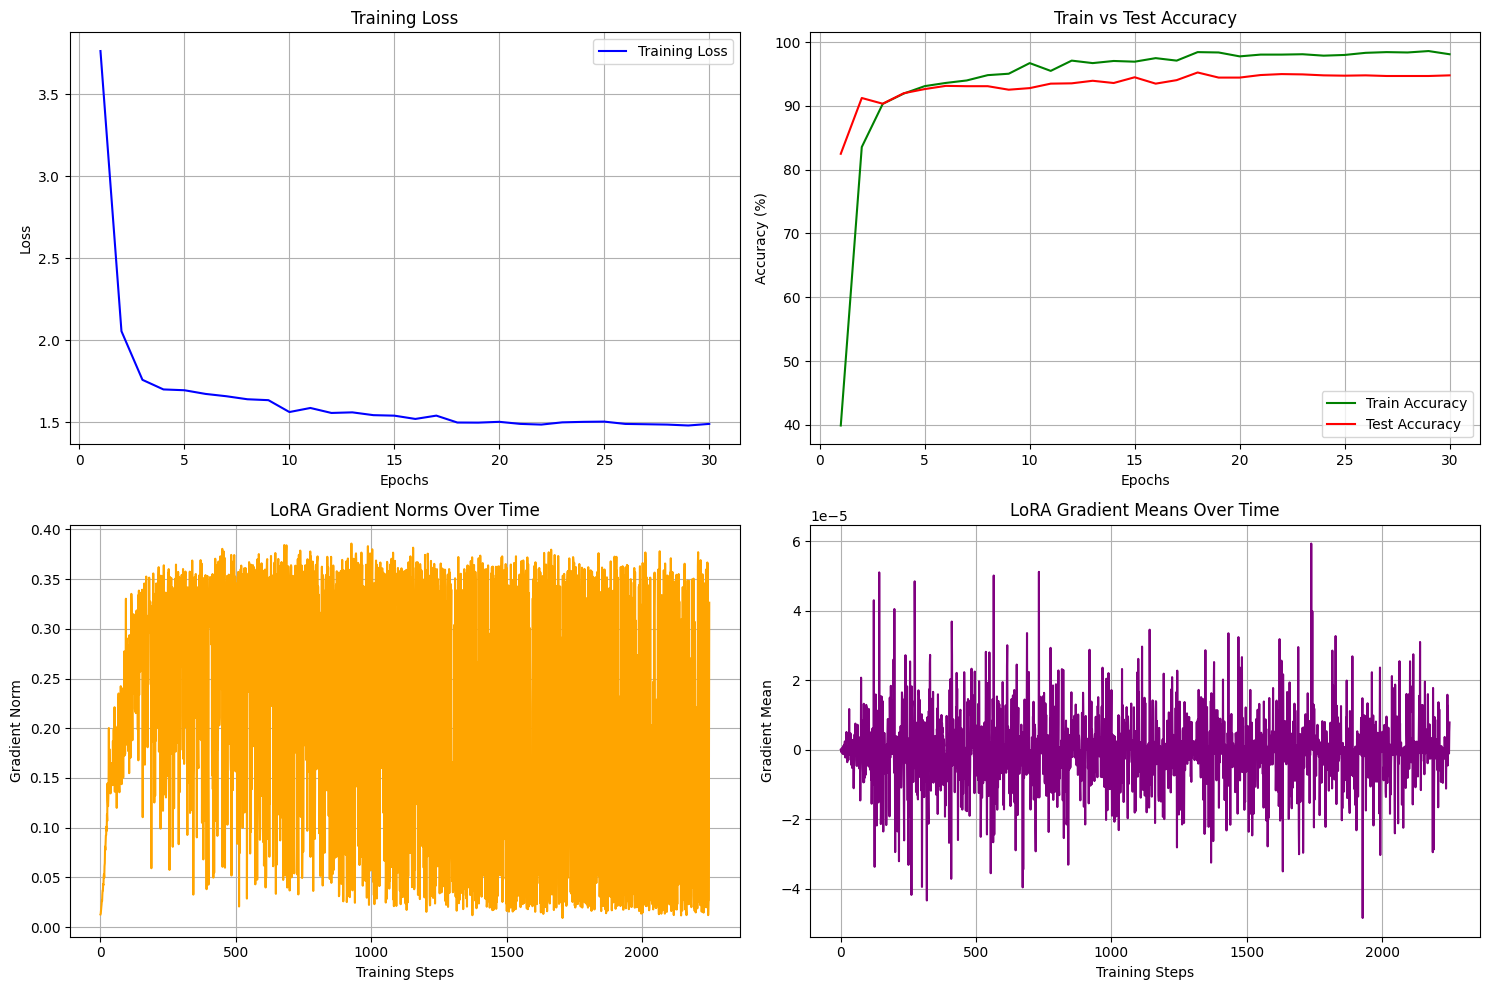


Best Results:
  Best Train Accuracy: 98.61%
  Best Test Accuracy: 95.25% (Epoch 18)
Final model saved!


In [18]:
# ==================== EXP 03 training loop ====================

# ==================== SUPERVISED CONTRASTIVE LOSS ====================
class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.2):
        super().__init__()
        self.temperature = temperature

    def forward(self, embeddings, labels):
        batch_size = embeddings.shape[0]
        
        # Normalize embeddings
        embeddings = F.normalize(embeddings, p=2, dim=1)
        
        # Compute similarity matrix
        similarity_matrix = torch.matmul(embeddings, embeddings.T) / self.temperature
        
        # Create mask for positive pairs
        labels = labels.contiguous().view(-1, 1)
        mask = torch.eq(labels, labels.T).float().to(embeddings.device)
        
        # Remove diagonal
        identity_mask = torch.eye(batch_size, device=embeddings.device)
        pos_mask = mask - identity_mask
        
        # Compute numerator and denominator
        exp_sim = torch.exp(similarity_matrix)
        pos_similarities = (pos_mask * exp_sim).sum(dim=1)
        neg_mask = 1 - identity_mask
        all_similarities = (neg_mask * exp_sim).sum(dim=1)
        
        # ========== CRITICAL FIX ==========
        # Handle cases with no positive pairs
        valid_pos_mask = (pos_mask.sum(dim=1) > 0).float()
        
        # For samples with positive pairs: compute normal loss
        # For samples without positive pairs: loss = 0 (or you could use a small constant)
        ratios = torch.zeros_like(pos_similarities)
        
        # Only compute ratios for valid samples
        valid_indices = valid_pos_mask.bool()
        if valid_indices.any():
            ratios[valid_indices] = pos_similarities[valid_indices] / (all_similarities[valid_indices] + 1e-8)
        
        # Compute loss only for valid samples
        loss = torch.zeros_like(ratios)
        loss[valid_indices] = -torch.log(ratios[valid_indices] + 1e-8)
        
        # Average only over samples that have positive pairs
        if valid_pos_mask.sum() > 0:
            loss = (loss * valid_pos_mask).sum() / valid_pos_mask.sum()
        else:
            # If no samples have positive pairs, return 0 loss
            loss = torch.tensor(0.0, device=embeddings.device, requires_grad=True)
        
        return loss



# ==================== TRAINING SETUP ====================
criterion_ce = nn.CrossEntropyLoss(label_smoothing=0.2)  #---------------------------------------------------------------
criterion_contrastive = SupervisedContrastiveLoss(temperature=0.2)

# Contrastive loss weight with warm-up
def get_contrastive_weight(epoch, total_epochs=10):
    """Gradually increase contrastive loss weight"""
    if epoch < 2:  # First 2 epochs: focus on classification
        return 0.05
    elif epoch < 5:  # Gradually increase
        return 0.2
    else:  # Full weight
        return 0.3

def get_temperature(epoch):
    """
    Annealing: Start loose (0.2) to let the model learn general shapes,
    then tighten (0.07) at the end to force precise clustering.
    """
    if epoch < 10: 
        return 0.2 
    if epoch < 20:
        return 0.15 
    else: 
        return 0.07  
        

trainable_params = [p for p in classifier.parameters() if p.requires_grad]
optimizer = AdamW(trainable_params, lr=1e-3, weight_decay=0.05) #-----------------------------------------------------------------
num_epochs = 30
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)
# ==================== MONITORING UTILITIES ====================
class TrainingMonitor:
    def __init__(self):
        self.train_losses = []
        self.train_accuracies = []
        self.test_accuracies = []
        self.lora_grad_norms = []
        self.lora_grad_means = []
        
    def update_lora_gradients(self, model, step):
        """Track LoRA gradient statistics"""
        grad_norms = []
        grad_means = []
        
        for name, param in model.named_parameters():
            if "lora" in name and param.requires_grad and param.grad is not None:
                grad_norms.append(param.grad.norm().item())
                grad_means.append(param.grad.mean().item())
        
        if grad_norms:
            self.lora_grad_norms.append((step, np.mean(grad_norms)))
            self.lora_grad_means.append((step, np.mean(grad_means)))
            
            if step % 20 == 0:  # Print every 20 steps
                print(f"[Step {step}] LoRA - Grad Norm: {np.mean(grad_norms):.6f}, Grad Mean: {np.mean(grad_means):.6f}")
    
    def plot_results(self):
        """Plot training curves and gradient statistics"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Training loss and accuracy
        epochs = range(1, len(self.train_losses) + 1)
        ax1.plot(epochs, self.train_losses, 'b-', label='Training Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training Loss')
        ax1.legend()
        ax1.grid(True)
        
        ax2.plot(epochs, self.train_accuracies, 'g-', label='Train Accuracy')
        ax2.plot(epochs, self.test_accuracies, 'r-', label='Test Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy (%)')
        ax2.set_title('Train vs Test Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        # LoRA gradient norms
        if self.lora_grad_norms:
            steps, norms = zip(*self.lora_grad_norms)
            ax3.plot(steps, norms, 'orange')
            ax3.set_xlabel('Training Steps')
            ax3.set_ylabel('Gradient Norm')
            ax3.set_title('LoRA Gradient Norms Over Time')
            ax3.grid(True)
        
        # LoRA gradient means
        if self.lora_grad_means:
            steps, means = zip(*self.lora_grad_means)
            ax4.plot(steps, means, 'purple')
            ax4.set_xlabel('Training Steps')
            ax4.set_ylabel('Gradient Mean')
            ax4.set_title('LoRA Gradient Means Over Time')
            ax4.grid(True)
        
        plt.tight_layout()
        plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
        plt.show()

monitor = TrainingMonitor()

# ==================== TRAINING FUNCTIONS ====================
def evaluate_model(model, test_loader):
    """Evaluate model on test set"""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            logits, _, _ = model(images)
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    accuracy = 100. * correct / total
    model.train()
    return accuracy
    
def train_one_epoch(model, train_loader, optimizer, epoch_idx):
    model.train()
    total_loss = 0
    total_ce_loss = 0
    total_con_loss = 0
    correct = 0
    total = 0
    step = 0
    
    alpha =get_contrastive_weight(epoch_idx) #--------------------------------------------------------------------
    
    current_temp = get_temperature(epoch_idx)
    criterion_contrastive.temperature = current_temp
    pbar = tqdm(train_loader, desc=f"Epoch {epoch_idx} [α={alpha:.2f}]")
    
    for batch_idx, (images, labels) in enumerate(pbar):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        logits,features, embeddings = model(images)
        
        # Calculate losses
        loss_ce = criterion_ce(logits, labels)
        loss_con = criterion_contrastive(embeddings, labels)
        
        # Combine losses
        loss = loss_ce  + (alpha * loss_con)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0) #----------------------------------
        # Monitor LoRA gradients
        global_step = (epoch_idx - 1) * len(train_loader) + batch_idx
        monitor.update_lora_gradients(model, global_step)
        
        # Optimizer step
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        total_ce_loss += loss_ce.item()
        total_con_loss += loss_con.item()
        
        _, predicted = logits.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        step += 1
        
        pbar.set_postfix({
            "Loss": f"{loss.item():.4f}", 
            "CE": f"{loss_ce.item():.4f}",
            "Con": f"{loss_con.item():.4f}",#loss_con.item():.4f
            "Acc": f"{100.*correct/total:.2f}%"
        })
    
    avg_loss = total_loss / len(train_loader)
    avg_ce = total_ce_loss / len(train_loader)
    avg_con = total_con_loss / len(train_loader)
    train_accuracy = 100. * correct / total
    
    print(f"Epoch {epoch_idx} Summary:")
    print(f"  Avg Loss: {avg_loss:.4f} (CE: {avg_ce:.4f}, Con: {avg_con:.4f})")
    print(f"  Train Accuracy: {train_accuracy:.2f}%")
    
    return avg_loss, train_accuracy

# ==================== MAIN TRAINING LOOP ====================
print(f"Starting training on {device}...")
print("Using Supervised Contrastive Loss with warm-up schedule")

for epoch in range(1, num_epochs + 1):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch}/{num_epochs}")
    print(f"{'='*50}")
    
    # Train for one epoch
    train_loss, train_acc = train_one_epoch(classifier, train_loader, optimizer, epoch)
    
    # Evaluate on test set
    test_acc = evaluate_model(classifier, test_loader)
    scheduler.step()
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")
    # Update monitoring
    monitor.train_losses.append(train_loss)
    monitor.train_accuracies.append(train_acc)
    monitor.test_accuracies.append(test_acc)
    
    print(f"Test Accuracy: {test_acc:.2f}%")
    
    # Save checkpoint
    if epoch % 5 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': classifier.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_acc': train_acc,
            'test_acc': test_acc,
        }, f"coca_lora_epoch_{epoch}.pt")
        print(f"Checkpoint saved for epoch {epoch}")

# ==================== FINAL RESULTS ====================
print(f"\n{'='*60}")
print("TRAINING COMPLETE!")
print(f"{'='*60}")

# Final evaluation
final_test_acc = evaluate_model(classifier, test_loader)
print(f"Final Test Accuracy: {final_test_acc:.2f}%")

# Plot results
monitor.plot_results()

# Print best results
best_train_acc = max(monitor.train_accuracies)
best_test_acc = max(monitor.test_accuracies)
best_epoch = monitor.test_accuracies.index(best_test_acc) + 1

print(f"\nBest Results:")
print(f"  Best Train Accuracy: {best_train_acc:.2f}%")
print(f"  Best Test Accuracy: {best_test_acc:.2f}% (Epoch {best_epoch})")

# Save final model
torch.save(classifier.state_dict(), "coca_lora_final.pt")
print("Final model saved!")

In [ ]:
contrastive 8,16 all 0.2       18-24  30 epochs 256 head
for 20 shot
for 24 batch 3*8

Loading CoCa backbone: coca_ViT-L-14...

Training: 10-Shot | Augmentation: LOW


Training: 100%|██████████| 10/10 [16:34<00:00, 99.42s/it, Loss=0.9584, Train Acc=99.6%, Val Acc=91.7%]



Final Best Validation Accuracy: 91.85%
Graph saved to monitor_10shot_low.png


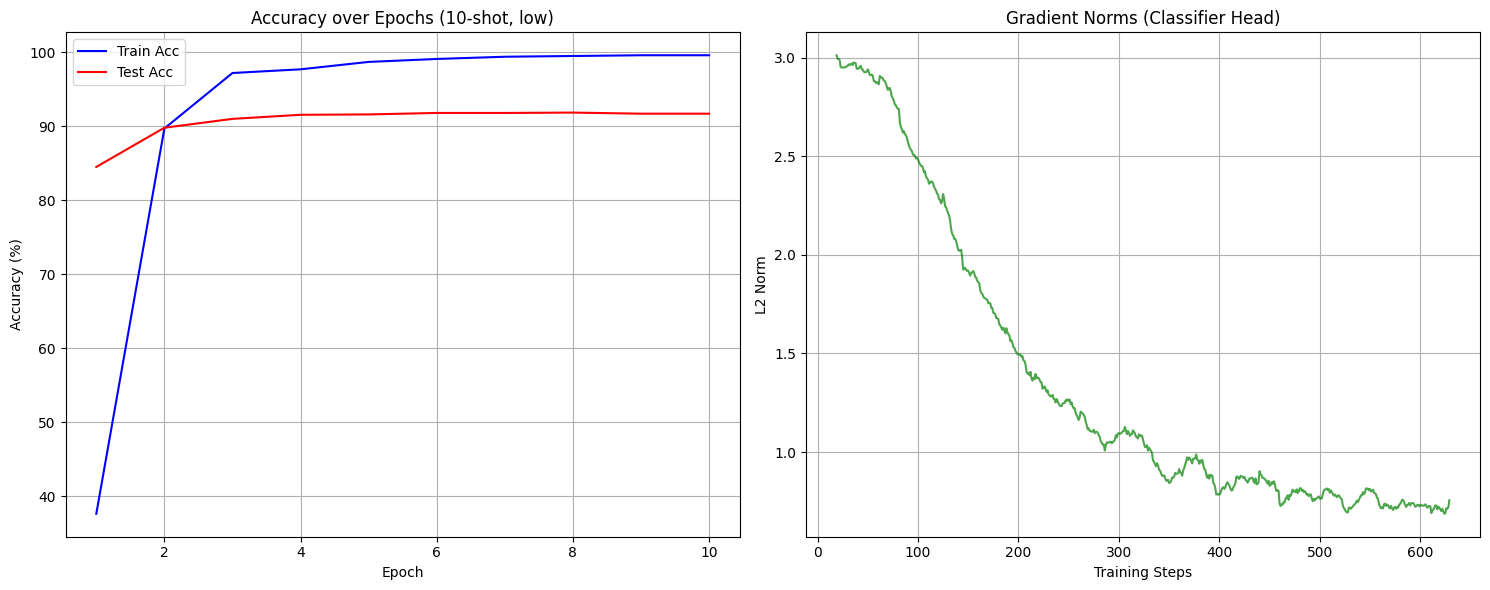

In [8]:
# ==================== EXP 02 ====================
import open_clip
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from pathlib import Path
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # Import tqdm

# ==================== 1. MONITORING & PLOTTING CLASS ====================
class TrainingMonitor:
    def __init__(self):
        self.epochs = []
        self.train_accs = []
        self.test_accs = []
        self.steps = []
        self.grad_norms = []
        
    def update_epoch(self, epoch, train_acc, test_acc):
        self.epochs.append(epoch)
        self.train_accs.append(train_acc)
        self.test_accs.append(test_acc)
        
    def update_step(self, step, model):
        # Calculate norm of gradients for the classifier head only
        total_norm = 0.0
        for p in model.classifier.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        
        self.steps.append(step)
        self.grad_norms.append(total_norm)

    def plot_results(self, n_shot, aug_level):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot 1: Accuracy
        ax1.plot(self.epochs, self.train_accs, 'b-', label='Train Acc')
        ax1.plot(self.epochs, self.test_accs, 'r-', label='Test Acc')
        ax1.set_title(f'Accuracy over Epochs ({n_shot}-shot, {aug_level})')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy (%)')
        ax1.legend()
        ax1.grid(True)
        
        # Plot 2: Gradient Norms
        window = 20 if len(self.steps) > 100 else 1
        if window > 1:
            smooth_grads = np.convolve(self.grad_norms, np.ones(window)/window, mode='valid')
            smooth_steps = self.steps[window-1:]
            ax2.plot(smooth_steps, smooth_grads, 'g-', alpha=0.7)
        else:
            ax2.plot(self.steps, self.grad_norms, 'g-', alpha=0.7)
            
        ax2.set_title('Gradient Norms (Classifier Head)')
        ax2.set_xlabel('Training Steps')
        ax2.set_ylabel('L2 Norm')
        ax2.grid(True)
        
        plt.tight_layout()
        filename = f"monitor_{n_shot}shot_{aug_level}.png"
        plt.savefig(filename)
        print(f"Graph saved to {filename}")
        
        # Explicitly show the plot in the notebook
        plt.show() 

# ==================== 2. MODEL & CONFIG ====================
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "coca_ViT-L-14"
pretrained = "mscoco_finetuned_laion2B-s13B-b90k"

print(f"Loading CoCa backbone: {model_name}...")
base_model, _, preprocess = open_clip.create_model_and_transforms(
    model_name=model_name, pretrained=pretrained
)

# Extract Normalization stats
mean = preprocess.transforms[-1].mean
std = preprocess.transforms[-1].std

class CoCaLinearProbe(nn.Module):
    def __init__(self, visual_encoder, num_classes=100, dropout=0.2): #----------------------------------------------
        super().__init__()
        self.visual = visual_encoder
        # Freeze Backbone
        for param in self.visual.parameters():
            param.requires_grad = False
            
        # Classifier Head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(768, num_classes)
        )
    
    def forward(self, x):
        with torch.no_grad():
            features, _ = self.visual(x) 
        return self.classifier(features)

# ==================== 3. AUGMENTATIONS ====================
def get_transforms(aug_level="low"):
    normalize = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    if aug_level == "none":
        return transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            normalize
        ])
    elif aug_level == "low":
        return transforms.Compose([
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            normalize
        ])
    elif aug_level == "high":
        return transforms.Compose([
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
            transforms.RandomGrayscale(p=0.2), 
            normalize
        ])
    else:
        raise ValueError(f"Unknown level: {aug_level}")

test_transform = get_transforms("none")

# ==================== 4. DATASET UTILS ====================
class FewShotDataset(Dataset):
    def __init__(self, data_dir: Path, transform=None):
        self.samples = []
        self.transform = transform
        class_dirs = sorted([d for d in data_dir.iterdir() if d.is_dir()])
        for idx, class_dir in enumerate(class_dirs):
            for ext in ["*.jpg", "*.jpeg", "*.png"]:
                for img_path in class_dir.glob(ext):
                    self.samples.append((img_path, idx))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform: image = self.transform(image)
        return image, label

class FewShotSubset(Dataset):
    def __init__(self, samples, transform):
        self.samples = samples
        self.transform = transform
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform: image = self.transform(image)
        return image, label

def create_few_shot_subset(dataset, n_shot, transform):
    samples_per_class = {}
    for img_path, label in dataset.samples:
        if label not in samples_per_class: samples_per_class[label] = []
        samples_per_class[label].append((img_path, label))
    
    few_shot_samples = []
    for label, samples in samples_per_class.items():
        k = min(len(samples), n_shot)
        selected = random.sample(samples, k)
        few_shot_samples.extend(selected)
    return FewShotSubset(few_shot_samples, transform)

# ==================== 5. TRAINING LOOP WITH PROGRESS BAR ====================
def train_linear_probe(n_shot, aug_level, epochs=15):
    print(f"\n{'='*50}")
    print(f"Training: {n_shot}-Shot | Augmentation: {aug_level.upper()}")
    print(f"{'='*50}")
    
    monitor = TrainingMonitor()

    # Data
    data_dir = Path("/kaggle/working/mini_imagenet_fewshot_renamed")
    train_source = FewShotDataset(data_dir / "train", transform=None)
    current_transform = get_transforms(aug_level)
    train_subset = create_few_shot_subset(train_source, n_shot, current_transform)
    test_set = FewShotDataset(data_dir / "test", transform=test_transform)
    
    train_loader = DataLoader(train_subset, batch_size=16, shuffle=True, num_workers=2) #---------------------------------------------
    test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)

    # Model & Opt
    model = CoCaLinearProbe(base_model.visual, num_classes=100).to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  #--------------------------------------------------------------------
    
    target_lr = 1e-3
    optimizer = optim.AdamW(model.classifier.parameters(), lr=target_lr, weight_decay=0.1)
    
    # === SCHEDULER CONFIGURATION ===
    warmup_epochs = 0  # Set to 0 to test without warmup
    decay_epochs = epochs - warmup_epochs
    
    if warmup_epochs > 0:
        # 1. Warmup Scheduler
        warmup_scheduler = optim.lr_scheduler.LinearLR(
            optimizer, 
            start_factor=0.001, 
            total_iters=warmup_epochs
        )
        
        # 2. Main Scheduler
        main_scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, 
            T_max=decay_epochs, 
            eta_min=1e-6
        )
        
        # 3. Combine them
        scheduler = optim.lr_scheduler.SequentialLR(
            optimizer, 
            schedulers=[warmup_scheduler, main_scheduler], 
            milestones=[warmup_epochs]
        )
    else:
        # === NO WARMUP CASE ===
        # Just use the main scheduler immediately
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, 
            T_max=epochs, 
            eta_min=1e-6
        )
    best_acc = 0.0
    global_step = 0

    # TQDM for Epochs
    pbar = tqdm(range(epochs), desc="Training")
    
    for epoch in pbar:
        model.train()
        correct = 0; total = 0
        train_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            
            monitor.update_step(global_step, model)
            global_step += 1
            
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        scheduler.step()
        train_acc = 100. * correct / total
        avg_loss = train_loss / len(train_loader)
        
        # Validation
        model.eval()
        val_correct = 0; val_total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                logits = model(images)
                _, predicted = logits.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_acc = 100. * val_correct / val_total
        if val_acc > best_acc: best_acc = val_acc
        
        monitor.update_epoch(epoch+1, train_acc, val_acc)
        
        # Update progress bar description with stats
        pbar.set_postfix({
            "Loss": f"{avg_loss:.4f}", 
            "Train Acc": f"{train_acc:.1f}%", 
            "Val Acc": f"{val_acc:.1f}%"
        })

    print(f"\nFinal Best Validation Accuracy: {best_acc:.2f}%")
    monitor.plot_results(n_shot, aug_level)
    return best_acc

def run_experiment_2():
    # Example: Run 1-shot with "None" augmentation
    train_linear_probe(n_shot=10, aug_level="low", epochs=10)

if __name__ == "__main__":
    run_experiment_2()